In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D

Using TensorFlow backend.


# Import du dataset et formatage des données

In [2]:
dataset = np.loadtxt('domineering.csv', delimiter=',')

In [3]:
data2 = dataset
data = data2
print('Taille du dataset:', len(data))
print(data)


Taille du dataset: 28155
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


A partir du dataset, on forme les matrices correspondant aux différentes informations du plateau :
* le board correspond à l'état du plateau
* flipped_board correspond à l'état inverse du plateau
* player définit le joueur qui doit jouer : une matrice de 0 pour le jeu vertical et une matrice de 1 pour le jeu horizontal
* move définit le coup à jouer, avec une seule position pour le domino à positionner : l'emplacement gauche d'un domino horizontal, l'emplacement haut d'un domino vertical

In [4]:
board = data.T[:64].T.reshape((len(data), 8, 8))
flipped_board = data.T[64:128].T.reshape((len(data), 8, 8))
player = data.T[128:192].T.reshape((len(data), 8, 8))
move = data.T[192:].T.reshape((len(data), 8, 8))

# Data augmentation

On cherche à augmenter le dataset en récupérant les 4 symétries des plateaux. 

Définition des fonctions permettant d'effectuer les symétries :

In [5]:
def get_syms(board):
    # on récupère les symétries horizontale, verticale, et des 2 diagonales du board :
    
    sym_horizontale = np.flipud(board)
    sym_verticale = np.fliplr(board)
    sym_diag_1 = np.rot90(sym_verticale)
    sym_diag_2 = np.rot90(sym_horizontale)
    syms = [board, sym_horizontale, sym_verticale, sym_diag_1, sym_diag_2]
    
    return syms


def get_complete_move(move, player):
    # on cherche le plateau avec les 2 emplacements de chaque domino, 
    # pour pouvoir faire les symétries du move avec le domino complet    
    
    complete_move = move.copy()   
    
    for i in range(len(move)):
        for j in range(len(move.T)):
            if move[i][j] == 1:
                if player[0][0] == 1:
                    complete_move[i][j+1] = 1
                else:
                    complete_move[i+1][j] = 1

    return complete_move
    
def get_simple_move_and_player_after_syms(complete_move, player):  
    # on revient à un plateau avec un seul emplacement par domino : 
    # l'emplacement gauche pour un domino horizontal, l'emplacement haut pour un domino vertical.    
    # Les symétries peuvent amener un domino horizontal à devenir vertical et inversement. On va
    # donc chercher le joueur correspondant en fonction de la direction du domino.
    
    move = []
    new_player = []
    
    for syms in complete_move: 
        simple_move = np.zeros((8,8))
        player2 = np.zeros((8,8))
        for i in range(len(syms)):
            for j in range(len(syms.T)):
                if j!=7 and syms[i][j] == 1 and syms[i][j+1] == 1:
                    simple_move[i][j] = 1
                    player2 = np.ones((8,8))
                elif i!=7 and syms[i][j] == 1 and syms[i+1][j] == 1:
                    simple_move[i][j] = 1
                    player2 = np.zeros((8,8))
        move.append(simple_move)
        new_player.append(player2)
    
    return move, new_player

In [6]:
data_augmented = []

for row in zip(board, flipped_board, player, move):
    
    # Pour chaque observation on récupère les différents boards
    board_row  = row[0]
    flipped_board_row = row[1]
    player_row = row[2]
    move_row = row[3]
        
    # Symmétries
    board_row_syms = get_syms(board_row)
    flipped_board_row_syms = get_syms(flipped_board_row)
    move_row_syms, player_row_syms = get_simple_move_and_player_after_syms(get_syms(get_complete_move(move_row, player_row)), player_row)

    syms = list(zip(board_row_syms, flipped_board_row_syms, player_row_syms, move_row_syms))
    data_augmented.extend(syms)

print("Taille du dataset augmenté avec les 4 symétries :", len(data_augmented))
print("Taille attendue :", len(board)*5)

Taille du dataset augmenté avec les 4 symétries : 140775
Taille attendue : 140775


# Modélisation

On commence par remettre à plat les différents boards pour chaque observation de façon à pouvoir splitter le jeu de données en Train et Test :

In [7]:
X = np.zeros((len(data_augmented),192))
y = np.zeros((len(data_augmented),64))
i=0
for row in data_augmented:
    X[i, 0:64] = row[0].flatten()
    X[i, 64:128] = row[1].flatten()
    X[i, 128:192] = row[2].flatten()
    y[i, 0:64] = row[3].flatten()
    i += 1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0, shuffle = True)

On retransforme les observations en matrices :

In [9]:
X_train = X_train.reshape(X_train.shape[0], 3, 8, 8)
X_test = X_test.reshape(X_test.shape[0], 3, 8, 8)
y_train = y_train.reshape(y_train.shape[0], 64)
y_test = y_test.reshape(y_test.shape[0], 64)

Pour la modélisation, différents optimizers ont été testés :
* Adadelta val_acc : 0.3866
* Adam val_acc : 03520
* Adamax val_acc : 0.3174
* Nadam val_acc : 0.3644
* RMSprop val_acc : 0.0303
* SGD val_acc : 0.3797

Différentes combinaisons de couches de neurones et de Dropout ont également été testées. 

In [17]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(3, 8, 8), padding="same"))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Dropout(0.25))
model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))
model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [18]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, mode='max') 
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Train on 114027 samples, validate on 12670 samples
Epoch 1/30
114027/114027 [==============================] - 165s 1ms/step - loss: 3.5256 - acc: 0.1230 - val_loss: 3.0521 - val_acc: 0.2334
Epoch 2/30
114027/114027 [==============================] - 140s 1ms/step - loss: 2.8440 - acc: 0.2764 - val_loss: 2.5958 - val_acc: 0.3199
Epoch 3/30
114027/114027 [==============================] - 135s 1ms/step - loss: 2.5533 - acc: 0.3306 - val_loss: 2.4041 - val_acc: 0.3543
Epoch 4/30
114027/114027 [==============================] - 151s 1ms/step - loss: 2.4327 - acc: 0.3517 - val_loss: 2.3550 - val_acc: 0.3624
Epoch 5/30
114027/114027 [==============================] - 180s 2ms/step - loss: 2.3562 - acc: 0.3662 - val_loss: 2.2743 - val_acc: 0.3746
Epoch 6/30
114027/114027 [==============================] - 198s 2ms/step - loss: 2.3127 - acc: 0.3737 - val_loss: 2.2391 - val_acc: 0.3853
Epoch 7/30
114027/114027 [==============================] - 205s 2ms/step - loss: 2.2759 - acc: 0.3824 - val_

Affichage du graphique de Loss :

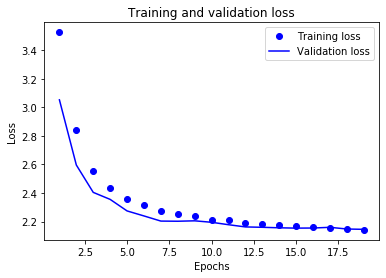

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Affichage du graphique d'Accuracy :

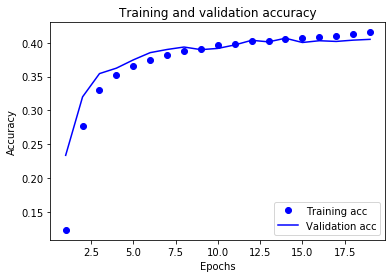

In [20]:
plt.clf() #Clears the figure
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test de l'accuracy du modèle sur le jeu de test :

In [21]:
pred_test = model.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))
print("Accuracy : %s " %acc)

Accuracy : 0.40112231851115215 


# Jeu

In [24]:
import random

def possible_moves(board, player):
    # on cherche tous les coups possibles à partir de l'état du jeu actuel
    
    moves=[]
    
    if player==0:      
        for i in range(8):
            for j in range(8):
                if board[i][j]==0 :
                    try :
                        if board[i+1][j] == 0 :
                            moves.append(i*8+j)
                    except:
                        error=0
    elif player==1:
        for i in range(8):
            for j in range(8):
                if board[i][j] == 0 :
                    try : 
                        if board[i][j+1] == 0 :
                            moves.append(i*8+j)
                    except :
                        error = 0
                    
    return moves     


def game(nb_parties):
    
    # on initialise les boards à 0 et on tire le premier joueur au hasard
    board = np.zeros((8, 8))
    flipped_board = np.zeros((8,8)) 
    player = random.randint(0,1)
    print("Le joueur %s commence la partie" % player)
    X = np.zeros((192))
    game_over = False
    n = 0
    
    # tant que le nombre total de parties n'est pas atteint et que le 
    # jeu n'est pas terminé :
    while n < nb_parties and game_over == False : 
        print("Partie ", n)
        
        #flipped board
        flipped_board = 1 - board
     
        #player
        if player == 0:
            player_board = np.zeros((8,8))
        elif player == 1:
            player_board = np.ones((8,8))
        
        # on crée le jeu à prédire par le modèle à partir de l'éat actuel du plateau 
        # et des boards créées ci-dessus (flipped_board et player)
        X[0:64] = board.flatten()
        X[64:128] = flipped_board.flatten()
        X[128:192] = player_board.flatten()
        X_pred = X.reshape(1, 3, 8, 8)
        
        # prédictions du coup à jouer
        y = model.predict(X_pred)
        
        # sélection du meilleur coup prédit
        # la prédiction a affecté des proba à chaque coup, il faut sélectionner
        # parmi les coups possibles, celui qui a la meilleure proba
        max_prob = -1
        for i in range(64):
            if y[0][i] > max_prob :
                max_prob = y[0][i]
                if i in possible_moves(board, player):
                    move = i
            else:
                max_prob=-1
            
        # nouvelle board correspondant au meilleur coup prédit
        i=move//8
        j=move%8
        board[i][j] += 1 #1ère position du domino
    
        # 2ème position du domino en fonction du joueur (0 vertical ou 1 horizontal)
        if player==0:
            board[i+1][j] = 1
        elif player==1:
            board[i][j+1] = 1    
         
        print("Le joueur ", player, "a", len(possible_moves(board, player)), "coups possibles")
        print("Le joueur ", 1-player, "a", len(possible_moves(board, 1-player)), "coups possibles")
        
        # Lorsqu'un joueur ne peut plus joueur, il a perdu la partie.
        if len(possible_moves(board, 1-player)) == 0:
            game_over = True
            print("Le joueur %s a gagné" % player)
        else:
            player = 1 -  player
            n += 1

On lance un jeu de 40 tours :

In [26]:
game(40)

Le joueur 1 commence la partie
Partie  0
Le joueur  1 a 54 coups possibles
Le joueur  0 a 54 coups possibles
Partie  1
Le joueur  0 a 52 coups possibles
Le joueur  1 a 50 coups possibles
Partie  2
Le joueur  1 a 48 coups possibles
Le joueur  0 a 50 coups possibles
Partie  3
Le joueur  0 a 48 coups possibles
Le joueur  1 a 45 coups possibles
Partie  4
Le joueur  1 a 43 coups possibles
Le joueur  0 a 46 coups possibles
Partie  5
Le joueur  0 a 44 coups possibles
Le joueur  1 a 43 coups possibles
Partie  6
Le joueur  1 a 42 coups possibles
Le joueur  0 a 42 coups possibles
Partie  7
Le joueur  0 a 40 coups possibles
Le joueur  1 a 42 coups possibles
Partie  8
Le joueur  1 a 40 coups possibles
Le joueur  0 a 38 coups possibles
Partie  9
Le joueur  0 a 36 coups possibles
Le joueur  1 a 36 coups possibles
Partie  10
Le joueur  1 a 34 coups possibles
Le joueur  0 a 34 coups possibles
Partie  11
Le joueur  0 a 32 coups possibles
Le joueur  1 a 32 coups possibles
Partie  12
Le joueur  1 a 30 co